In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import resnet18

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.is_available()

True

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), #превращение картинки в тензор
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #значение нормализации

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=4)

In [6]:
class SimpleNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        #3x32x32
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3), padding=1)
        self.act1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=1)
        self.act2 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=(2,2))

        #64x16x16
        self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1)
        self.act3 = torch.nn.ReLU()
        self.conv4 = torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), padding=1)
        self.act4 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=(2,2))

        #128x8x8
        self.conv5 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), padding=1)
        self.act5 = torch.nn.ReLU()
        self.conv6 = torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), padding=1)
        self.act6 = torch.nn.ReLU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=(2,2))

        #256x4x4
        self.conv7 = torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), padding=1)
        self.act7 = torch.nn.ReLU()
        self.conv8 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), padding=1)
        self.act8 = torch.nn.ReLU()
        self.pool4 = torch.nn.MaxPool2d(kernel_size=(2,2))

        #512x2x2
        self.conv9 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), padding=1)
        self.act9 = torch.nn.ReLU()
        self.conv10 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), padding=1)
        self.act10 = torch.nn.ReLU()
        self.pool5 = torch.nn.MaxPool2d(kernel_size=(2,2))

        #512x1x1
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(in_features=512, out_features=1024)
        self.fc2 = torch.nn.Linear(in_features=1024, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool1(x)

        #64x16x16
        x = self.conv3(x)
        x = self.act3(x)
        x = self.conv4(x)
        x = self.act4(x)
        x = self.pool2(x)

        #128x8x8
        x = self.conv5(x)
        x = self.act5(x)
        x = self.conv6(x)
        x = self.act6(x)
        x = self.pool3(x)

        #256x4x4
        x = self.conv7(x)
        x = self.act7(x)
        x = self.conv8(x)
        x = self.act8(x)
        x = self.pool4(x)

        #512x2x2
        x = self.conv9(x)
        x = self.act9(x)
        x = self.conv10(x)
        x = self.act10(x)
        x = self.pool5(x)

        #512x1x1
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

Создание кастомной сетки на основе архитектуры VGG16

In [7]:
net = SimpleNet().to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [8]:
for epoch in range(10):

    net.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() #градиент обнуляется
        predictions = net(images)

        correct += (labels == predictions.argmax(dim=1,)).sum()
        total += len(labels)

        loss = loss_function(predictions, labels)
        loss.backward() #производная
        optimizer.step() #шаг градиента

        epoch_loss += loss.item()

    print(f'Epoch {epoch} | train: loss {epoch_loss / len(train_loader)} | accuracy {correct / total}')
    
    net.eval()
    epoch_loss = 0
    correct = 0
    total = 0

    for batch in test_loader:

        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        predictions = net(images)

        correct += (labels == predictions.argmax(dim=1,)).sum()
        total += len(labels)

        with torch.no_grad(): 
            loss = loss_function(predictions, labels)

        epoch_loss += loss.item()

    print(f'Epoch {epoch} | test: loss {epoch_loss / len(test_loader)} | accuracy {correct / total}')

Epoch 0 | train: loss 1.8818340792375452 | accuracy 0.2630600035190582
Epoch 0 | test: loss 1.7065457141399383 | accuracy 0.3384999930858612
Epoch 1 | train: loss 1.5250183331692004 | accuracy 0.41725999116897583
Epoch 1 | test: loss 1.4131851482391358 | accuracy 0.47349998354911804
Epoch 2 | train: loss 1.318099138376963 | accuracy 0.5076999664306641
Epoch 2 | test: loss 1.258338383436203 | accuracy 0.5385000109672546
Epoch 3 | train: loss 1.1719347182137276 | accuracy 0.5681399703025818
Epoch 3 | test: loss 1.1287186795473099 | accuracy 0.593999981880188
Epoch 4 | train: loss 1.0287865944530652 | accuracy 0.6230599880218506
Epoch 4 | test: loss 0.9939325302839279 | accuracy 0.6360999941825867
Epoch 5 | train: loss 0.9233466578871393 | accuracy 0.6628999710083008
Epoch 5 | test: loss 0.9814717435836792 | accuracy 0.651699960231781
Epoch 6 | train: loss 0.8159311872614009 | accuracy 0.7036600112915039
Epoch 6 | test: loss 0.8523812091350556 | accuracy 0.6972000002861023
Epoch 7 | train

In [9]:
net = resnet18(pretrained=True)
#net.fc = torch.nn.Linear(in_features=512, out_features=10, bias=True) #замена последнего слоя на 10 классов (вместо 1000)
net = net.to(device)

In [10]:
for epoch in range(10):

    net.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() #градиент обнуляется
        predictions = net(images)

        correct += (labels == predictions.argmax(dim=1,)).sum()
        total += len(labels)

        loss = loss_function(predictions, labels)
        loss.backward() #производная
        optimizer.step() #шаг градиента

        epoch_loss += loss.item()

    print(f'Epoch {epoch} | train: loss {epoch_loss / len(train_loader)} | accuracy {correct / total}')
    
    net.eval()
    epoch_loss = 0
    correct = 0
    total = 0

    for batch in test_loader:

        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        predictions = net(images)

        correct += (labels == predictions.argmax(dim=1,)).sum()
        total += len(labels)

        with torch.no_grad(): 
            loss = loss_function(predictions, labels)

        epoch_loss += loss.item()

    print(f'Epoch {epoch} | test: loss {epoch_loss / len(test_loader)} | accuracy {correct / total}')

Epoch 0 | train: loss 13.623211143571702 | accuracy 0.0012199999764561653
Epoch 0 | test: loss 13.87098038673401 | accuracy 0.0005999999702908099
Epoch 1 | train: loss 13.615610808057859 | accuracy 0.0007800000021234155
Epoch 1 | test: loss 13.78180323600769 | accuracy 0.0007999999797903001
Epoch 2 | train: loss 13.606173876301407 | accuracy 0.0007800000021234155
Epoch 2 | test: loss 14.211358842849732 | accuracy 0.0007999999797903001
Epoch 3 | train: loss 13.620719999913364 | accuracy 0.0009999999310821295
Epoch 3 | test: loss 13.94668698310852 | accuracy 0.000699999975040555
Epoch 4 | train: loss 13.627344277813611 | accuracy 0.0006599999614991248
Epoch 4 | test: loss 13.684418697357177 | accuracy 0.0009999999310821295
Epoch 5 | train: loss 13.629526789535952 | accuracy 0.0007800000021234155
Epoch 5 | test: loss 13.897808332443237 | accuracy 0.0009999999310821295
Epoch 6 | train: loss 13.62234100234478 | accuracy 0.0010400000028312206
Epoch 6 | test: loss 13.793641529083253 | accurac

In [11]:
img_tensor = next(iter(trainset))[0]

In [12]:
img_tensor.size(), np.moveaxis(img_tensor.numpy(), 0, 2).shape

(torch.Size([3, 32, 32]), (32, 32, 3))

In [13]:
image = np.moveaxis(img_tensor.numpy(), 0, 2)

In [14]:
image = image * np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5])

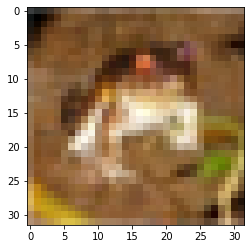

In [15]:
plt.imshow(image)

In [16]:
class PixelRegressionDataset(torch.utils.data.Dataset):
    def __init__(self, donor_dataset):
        self.donor_dataset = donor_dataset

    def __len__(self):
        return len(self.donor_dataset)

    def __getitem__(self, index):
        img_tensor, object_label = self.donor_dataset[index]
        channels, h, w = img_tensor.size()
        x = np.random.randint(w)
        y = np.random.randint(h)
        img_tensor[1:2, x, y] = -1 #рандомный пиксель перекрашивается
        return {'image' : img_tensor, 'xy' : torch.FloatTensor([x,y]), 'label' : object_label} #возвращается изображение и координаты пикселя

In [17]:
def imshow(img_tensor):
    image = np.moveaxis(img_tensor.numpy(), 0, 2)
    image = image * np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5])
    plt.imshow(image)
    plt.show()

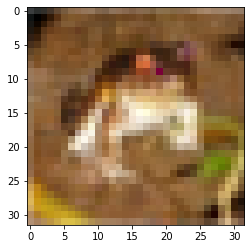

In [18]:
imshow(next(iter(PixelRegressionDataset(trainset)))['image'])

## Localisation

In [19]:
train_loader = torch.utils.data.DataLoader(PixelRegressionDataset(trainset), batch_size=128,
                                          shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(PixelRegressionDataset(testset), batch_size=100,
                                         shuffle=False, num_workers=4)

In [20]:
net = resnet18(pretrained=True)
net.fc = torch.nn.Linear(in_features=512, out_features=12, bias=True) #замена последнего слоя на 10 классов (вместо 1000)
net = net.to(device)

In [21]:
loss_function_xy = torch.nn.L1Loss()
loss_function_CE = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [22]:
for epoch in range(10):

    net.train()
    epoch_loss = 0

    for batch in train_loader:
        
        images, xy, labels = batch['image'], batch['xy'], batch['label']
        images = images.to(device)
        labels = labels.to(device)
        xy = xy.to(device)

        optimizer.zero_grad() #градиент обнуляется
        predictions = net(images)

        loss = loss_function_xy(predictions[:, 10:], xy) + loss_function_CE(predictions[:, :10], labels)
        loss.backward() #производная
        optimizer.step() #шаг градиента

        epoch_loss += loss.item()

    epoch_loss_train = epoch_loss / len(train_loader)
    
    net.eval()
    epoch_loss = 0

    for batch in test_loader:
        
        images, xy, labels = batch['image'], batch['xy'], batch['label']
        images = images.to(device)
        labels = labels.to(device)
        xy = xy.to(device)

        predictions = net(images)

        with torch.no_grad(): 
            loss = loss_function_xy(predictions[:, 10:], xy) + loss_function_CE(predictions[:, :10], labels)

        epoch_loss += loss.item()

    print(f'Epoch {epoch} | train loss {epoch_loss_train}| test loss {epoch_loss / len(test_loader)}')

Epoch 0 | train loss 9.243865821672523| test loss 8.355304932594299
Epoch 1 | train loss 5.591147956945707| test loss 3.9746339297294617
Epoch 2 | train loss 3.5687560815640422| test loss 3.20076092004776
Epoch 3 | train loss 3.0178528203988626| test loss 2.673609733581543
Epoch 4 | train loss 2.689346623847552| test loss 2.4968806219100954
Epoch 5 | train loss 2.3964335820863925| test loss 2.167443401813507
Epoch 6 | train loss 2.259803331416586| test loss 2.142678954601288
Epoch 7 | train loss 2.1104798573057364| test loss 2.185953985452652
Epoch 8 | train loss 1.974937289572128| test loss 2.2112229478359224
Epoch 9 | train loss 1.8453470008147648| test loss 1.9271371519565583


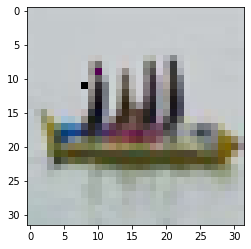

tensor(1, device='cuda:0') tensor(8, device='cuda:0')


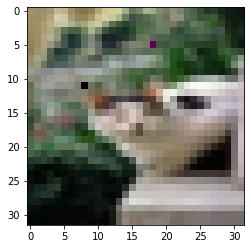

tensor(1, device='cuda:0') tensor(8, device='cuda:0')


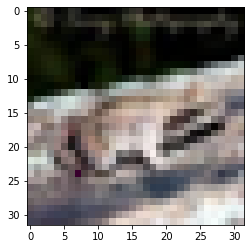

tensor(1, device='cuda:0') tensor(8, device='cuda:0')


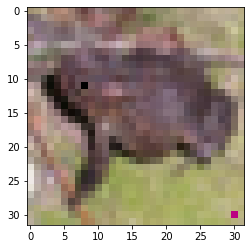

tensor(1, device='cuda:0') tensor(8, device='cuda:0')


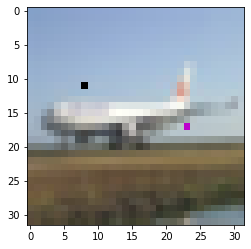

tensor(1, device='cuda:0') tensor(8, device='cuda:0')


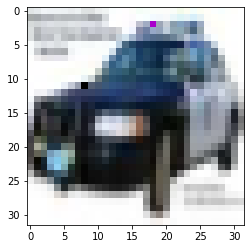

tensor(1, device='cuda:0') tensor(8, device='cuda:0')


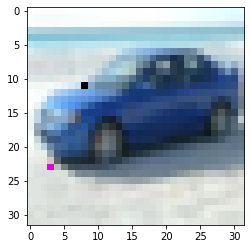

tensor(1, device='cuda:0') tensor(8, device='cuda:0')


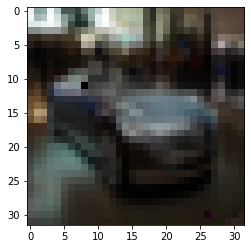

tensor(1, device='cuda:0') tensor(8, device='cuda:0')


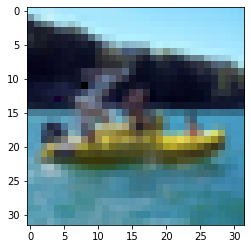

tensor(1, device='cuda:0') tensor(8, device='cuda:0')


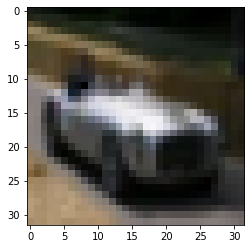

tensor(1, device='cuda:0') tensor(8, device='cuda:0')


In [23]:
for i in range(10):
    image_tensor = images[i].cpu().clone()
    x, y = predictions[0, 10:].cpu().round().int()
    image_tensor[:, y.item(), x.item()] = -1
    imshow(image_tensor)
    print(predictions[0, 10:].argmax(dim=0), labels[0])